# Genept sample execution

## 1) Imports 
Let's start by importing all the packages used in this notebook

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoModel
from helical.models.genept import GenePTConfig

import umap
import matplotlib.pyplot as plt
import seaborn as sns


/home/giovanni/miniconda3/envs/env_helical/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.
INFO:datasets:TensorFlow version 2.17.0 available.
2025-01-16 18:14:09.628592: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 18:14:09.637188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 18:14:09.646540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN fact

In [2]:
%load_ext autoreload
%autoreload 2
from helical.models.genept.model import GenePT, GenePTConfig
from datasets import load_dataset
from helical.utils import get_anndata_from_hf_dataset

## 2) Load the model
Here we load the GenePT model. 
The first time the model is loaded, a file containing pre-computed embeddings is dowloanded and cached locally. This file will be used at every successive run.

In [3]:
genept_config = GenePTConfig(device="cuda")
genept = GenePT(configurer = genept_config)

INFO:helical.models.genept.model:GenePT initialized successfully.


## 3) Load and prepare the dataset

We first load the human fetal yolk sac scRNA-seq data from the Helical Hugging Face datasets.

The yolk sac (YS) generates the first blood and immune cells and provides nutritional and metabolic support to the developing embryo.

There are three granularity levels of cell annotation you can access in the data. In this notebook we'll use the least granular LVL1 cell annotation.

In [4]:
# either load via huggingface
hf_dataset = load_dataset("helical-ai/yolksac_human",split="train[:5%]", trust_remote_code=True, download_mode="reuse_cache_if_exists")
ann_data = get_anndata_from_hf_dataset(hf_dataset)

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1987.53 examples/s]


Convert the dataset into Hugging Face dataset format. This is the format used by Helical models to train, predict and get embeddings.

In [5]:
data = genept.process_data(ann_data)
data.X = data.X.toarray().copy()

Generate the embeddings

In [6]:
embs = genept.get_embeddings(data)
print(embs.shape)

INFO:helical.models.genept.model:Inference started:
INFO:helical.models.genept.model:Inference started:
INFO:helical.models.genept.model:Couln't find 61 genes in embeddings


torch.Size([1267, 4096])


### 3.2) Visualization with UMAP
Let's visualize the embeddings leveraging UMAP.

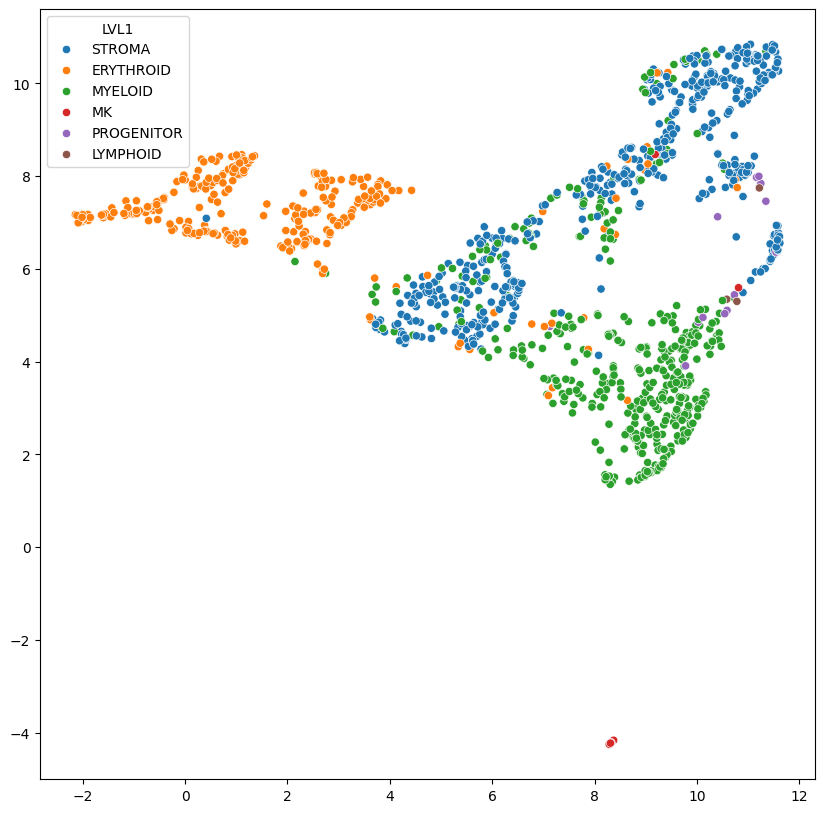

In [7]:
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine').fit_transform(embs)

plt.figure(figsize=(10,10))
sns.scatterplot(x=umap_emb[:,0],y=umap_emb[:,1],hue=data.obs['LVL1'])
plt.show()